# Training and Evaluating the Tumor Detection Model

I spent a lot of time thinking about the architecture of my model in order to incorperate the different zoom levels. I wanted to use the InceptionV3 model for each zoom level with imagenet weights, as the paper says it is able to speed up training time. I attempted to work on my own model; however, I was not able to acheive the AUC that I was able to achieve simply with transfer learning. Hence I continued using the InceptionV3 model. 

I was encountering the issue with keras where it would not allow me to have multiple InceptionV3 models in the same model. So instead I decided to train InceptionV3 models and train them against the labels we have from trianing data. This then would update the weights in the model and create a representaion of the cancerous cells. Thus I simple created a lower dimension vector as embedding from the last layer of the InceptionV3 model and then used it as an embedding for the images. 

With the 3 models for the 3 zoom levels, I would get 3 embedding vectors for one region of a slide. Then I concatenate the vectors and input them into a dense network, which is trained on the weights. This final model takes into account the features that are picked up at each zoom level.

Unforunately, with the multiple zoom levels, as seen in the paper, I did not see a large gain in performance.

Model structure:
![](https://i.imgur.com/zpPWcIF.png)

### Prepping Libraries and Data

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install Augmentor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (139 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
import h5py
from skimage.color import rgb2gray
from tqdm.notebook import tqdm
from collections import defaultdict
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras import models,layers
import Augmentor
import torchvision
from sklearn.metrics import roc_auc_score

For quick evaluation I have links to download my data and model

In [ ]:
!wget https://storage.googleapis.com/cs4995_slk2181/data_4.zip
!wget https://storage.googleapis.com/cs4995_slk2181/model_v4.zip
!wget https://storage.googleapis.com/cs4995_slk2181/model_ensemble.h5

--2020-12-22 19:15:58--  https://storage.googleapis.com/cs4995_slk2181/data_4.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 142.250.125.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4132355578 (3.8G) [application/zip]
Saving to: ‘data_4.zip’

data_4.zip          100%[===================>]   3.85G  76.5MB/s    in 35s     

2020-12-22 19:16:33 (112 MB/s) - ‘data_4.zip’ saved [4132355578/4132355578]

--2020-12-22 19:16:36--  https://storage.googleapis.com/cs4995_slk2181/model_v3.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 685696610 (654M) [application/zip]
Saving to: ‘model_v3.zip’

model_v3.zip      

In [ ]:
!unzip -qq data_4.zip
!unzip -qq model_v3.zip

Below I reorganize the folder structure so it is easier to train the seperate zoom models.


In [ ]:
def make_dirs(base_dir,lvl):
    new_dir = base_dir + '_lvl' + str(lvl)

    !mkdir $new_dir
    !mkdir $new_dir/1
    !mkdir $new_dir/0

    !cp $base_dir/1/lvl$lvl/* $new_dir/1/.
    !cp $base_dir/0/lvl$lvl/* $new_dir/0/.

make_dirs('train',2)
make_dirs('val',2)
make_dirs('train',3)
make_dirs('val',3)
make_dirs('train',5)
make_dirs('val',5)

### Creating Data Generators and Augmenting the Data

I decided to use the keras ImageDataGenerator with a python package [Augmentor](https://github.com/mdbloice/Augmentor). I used this package, as it offers the elastic distortion agumentation. I thought it might be useful as it was used in a paper with blood cells in order to curb overfitting. 

In [ ]:
import tensorflow as tf

img_height = 299
img_width = 299
batch_size = 32

train_dir = '/content/train_lvl2'
val_dir = '/content/val_lvl2'

p = Augmentor.Pipeline()
p.rotate_random_90(0.5)
p.flip_random(0.5)
p.random_distortion(0.7, 10, 10, 5)

In [ ]:
def augment(p):
    '''
    This function returns a function for an ImageDataGenerator
    to apply to images.
    '''
    def _augment(img):
        img = Image.fromarray(np.uint8(img))
        for operation in p.operations:
            r = random.uniform(0, 1)
            if r < operation.probability:
                img = operation.perform_operation([img])[0]
        return img

    return _augment

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(preprocessing_function=augment(p))
train_generator = img_gen.flow_from_directory(
  train_dir,
  class_mode='binary',
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

val_ds_lvl2 = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  label_mode='binary',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35571 images belonging to 2 classes.
Found 4667 files belonging to 2 classes.


Below are a sample of 9 augmented images. The black image in the corner is due to 2 black crosses found on the first slide.

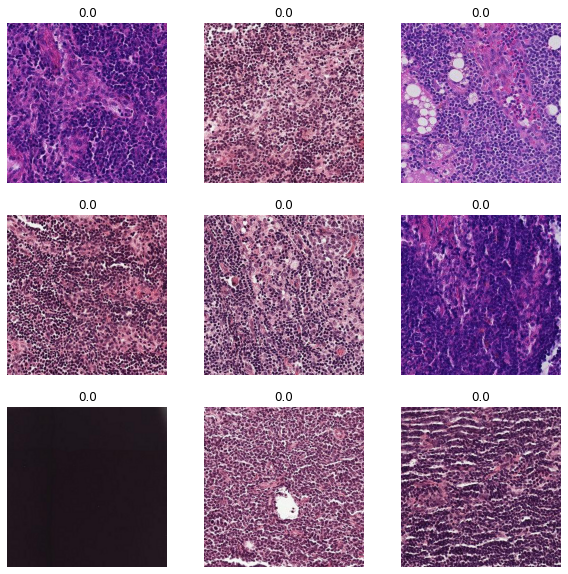

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = Image.fromarray(np.uint8(images[i]))
        plt.imshow(img)
        plt.title(str(labels[i]))
        plt.axis("off")
    break

## Creating the Models


### Highest Zoom Model

In [ ]:
train_generator = img_gen.flow_from_directory(
  train_dir,
  class_mode='binary',
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 35571 images belonging to 2 classes.


Here is the first model for zoom Level 2. It has an IncpetionV3 model which feeds into a GlobalAveragePooling2D layer which helps flatten the representation into a much smaller embedding of 2048 (which we will use later on). The final layer is a our Dense layer which gives us our output for the crop whether it is cancerous or not. Training this model on the zoom level will update the weights and thus allow that 2048 layer to have a good representation for whether a certain region of a slide is cancerous.

In [ ]:
IMG_SHAPE = (299,299,3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
model_lvl2 = tf.keras.Sequential([base_model,layers.GlobalAveragePooling2D(),layers.Dense(1,activation='sigmoid')])
model_lvl2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model_lvl2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = 'adam',
              metrics=[tf.keras.metrics.AUC()])

Due to the model complexity and amount of training data, if I run it more than one epoch, the model tends to overfit. I tried different architectures and hyperparameters and have come to the conclusion that the Level 2 zoom level is ultimately bottlenecking the model's ability to pick up more fine grain patterns and thus the validation AUC seen below is the upper limit of what I have been able to achieve.

In [ ]:
history = model_lvl2.fit(train_generator, validation_data=val_ds_lvl2, epochs=5,verbose=1, batch_size=batch_size)

Epoch 1/5
1112/1112 [==============================] - 474s 419ms/step - loss: 0.1152 - auc_10: 0.9761 - val_loss: 0.7955 - val_auc_10: 0.7821
Epoch 2/5
1112/1112 [==============================] - 467s 420ms/step - loss: 0.0595 - auc_10: 0.9925 - val_loss: 0.2223 - val_auc_10: 0.8911
Epoch 3/5
1112/1112 [==============================] - 468s 421ms/step - loss: 0.0525 - auc_10: 0.9935 - val_loss: 0.3123 - val_auc_10: 0.7496
Epoch 4/5
1112/1112 [==============================] - 469s 422ms/step - loss: 0.0525 - auc_10: 0.9947 - val_loss: 0.4442 - val_auc_10: 0.7789
Epoch 5/5
1112/1112 [==============================] - 467s 420ms/step - loss: 0.0492 - auc_10: 0.9950 - val_loss: 0.2745 - val_auc_10: 0.8326


In [ ]:
model_lvl2.save('model_v4_lvl2.h5')

In [ ]:
model_lvl2 = models.load_model('model_v4_lvl2.h5')

#### Testing Model *Performance*

In [ ]:
# these are methods from the preprocessing notebook and are used for the testing
# portion
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
def inference_slide(slide,tumor_mask,level):
    '''
    This method is almos identical with the one in the preprocessing notebooks,
    except instead of saving the images, we simply predict using our model above.
    '''
    size = 299
    stride = 128
    overlap = size // stride 
    padding = (size - stride) // 2

    num_cols = slide.level_dimensions[level][0] // stride - overlap
    num_rows = slide.level_dimensions[level][1] // stride - overlap

    label_img = np.zeros([num_rows,num_cols])
    predicted = np.zeros([num_rows,num_cols])

    y_true = []
    y_pred = []

    for y_s in tqdm(range(num_rows)):
        for x_s in range(num_cols):
            x_tl = x_s * int(slide.level_downsamples[level]) * stride
            y_tl = y_s * int(slide.level_downsamples[level]) * stride

            slide_image = read_slide(slide,x= x_tl,y= y_tl,level=level,width=size,height=size)
            tissue_pixels = find_tissue_pixels(slide_image)
            percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0])
            if percent_tissue > 0.8:
                predicted[y_s,x_s] = model_lvl2.predict(np.expand_dims(slide_image,axis=0))
                y_pred.append(predicted[y_s,x_s])

                mask_image = read_slide(tumor_mask,x= x_tl+padding,y= y_tl+padding,level=level,width=stride,height=stride)
                mask_image = mask_image[:,:,0]
                
                if np.any(mask_image):
                    label_img[y_s,x_s] = 1
                    y_true.append(1)
                else:
                    label_img[y_s,x_s] = 0
                    y_true.append(0)
            else: 
                label_img[y_s,x_s] = 0
                predicted[y_s,x_s] = 0

    print('Label')
    plt.figure(figsize=(10,10))
    plt.imshow(label_img)
    plt.show()

    print('Predicted')
    plt.figure(figsize=(10,10))
    plt.imshow(predicted)
    plt.show()

    auc = roc_auc_score(y_true,y_pred)

    print('AUC for image:',str(auc))

In [ ]:
def get_slide(url_slide):
    if 'mask' in url_slide[0]:
        slide_path = url_slide[1]
        tumor_mask_path = url_slide[0]

        slide_path_file = slide_path.rsplit('/', 1)[-1]        
        tm_path_file = tumor_mask_path.rsplit('/', 1)[-1]
    else:
        slide_path = url_slide[0]
        tumor_mask_path = url_slide[1]

        slide_path_file = slide_path.rsplit('/', 1)[-1]        
        tm_path_file = tumor_mask_path.rsplit('/', 1)[-1]

    if not os.path.exists(slide_path_file):
        !curl -O $slide_path

    if not os.path.exists(tm_path_file):
        !curl -O $tumor_mask_path

    slide = open_slide(slide_path_file)
    tumor_mask = open_slide(tm_path_file)

    print(slide_path_file)
    print(tm_path_file)
    
    for i in range(len(slide.level_dimensions)-1):
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    
    return (slide,tumor_mask,slide_path_file,tm_path_file) 

In [ ]:
def gather_urls(filename):
    urls = defaultdict(list)
    with open(filename,'r') as f:
        for line in f.read().splitlines():
            image = line.rsplit('/', 1)[-1][:9]
            if '.tif' in line:
                urls[image].append(line)
    return urls

The code below runs the model on the test slides and evalutes how well it did.

tumor_094.tif
tumor_094_mask.tif



Label


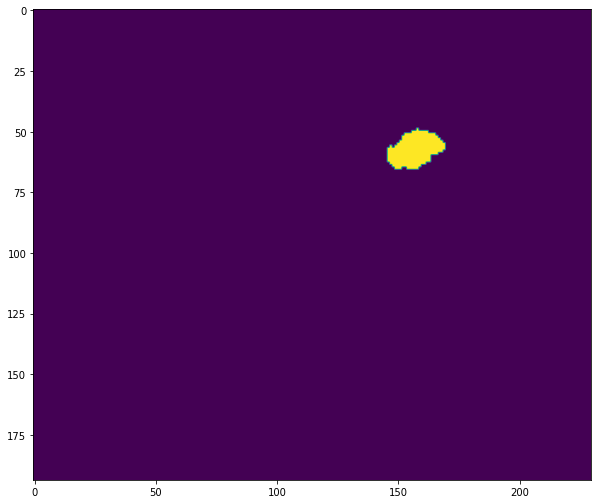

Predicted


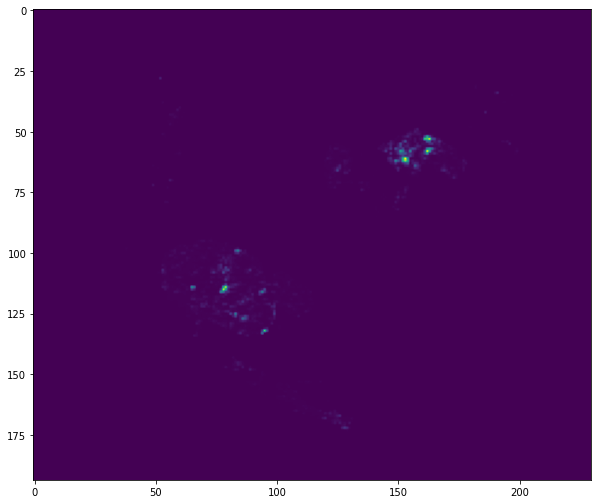

AUC for image: 0.8402401605003835
tumor_096.tif
tumor_096_mask.tif



Label


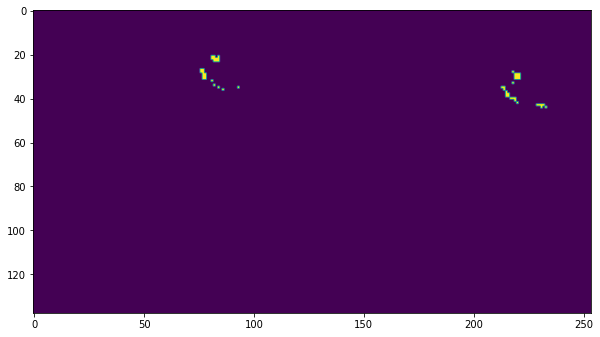

Predicted


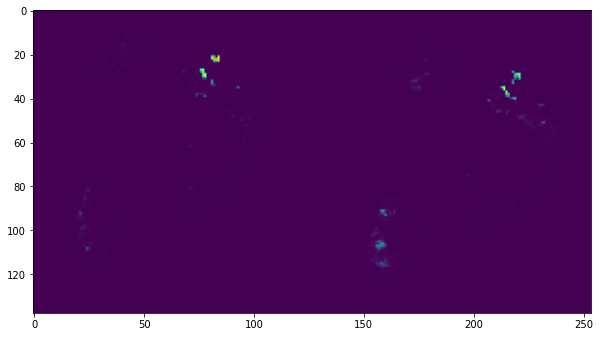

AUC for image: 0.9762663832801984
tumor_101.tif
tumor_101_mask.tif



Label


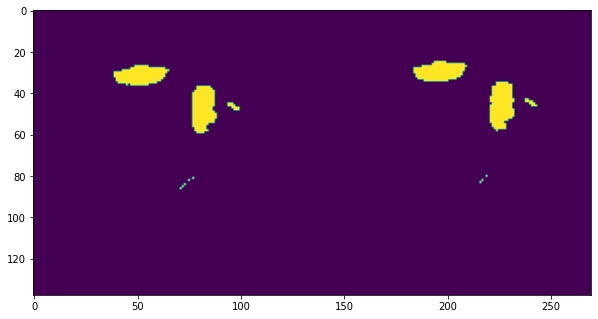

Predicted


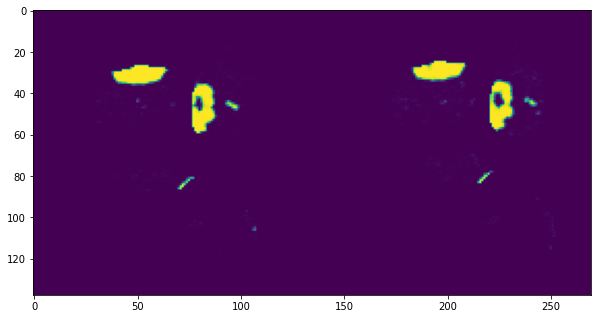

AUC for image: 0.9879187744923406
tumor_110.tif
tumor_110_mask.tif



Label


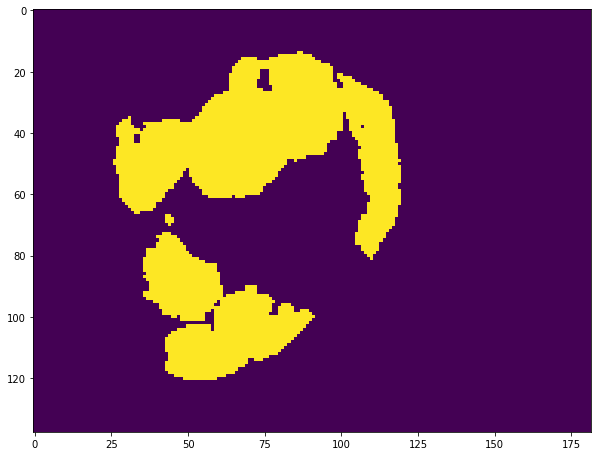

Predicted


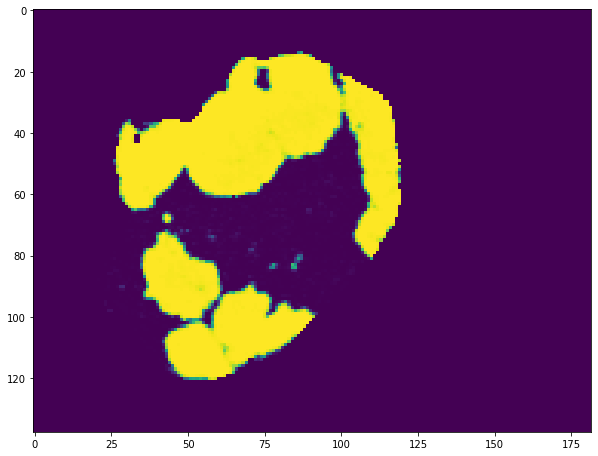

AUC for image: 0.9959905565171078


In [ ]:
images = ['tumor_094','tumor_096','tumor_101','tumor_110']
urls = gather_urls('test_links.txt')
for image in images:
    slide,tumor_mask,slide_path_file,tm_path_file = get_slide(urls[image])
    inference_slide(slide,tumor_mask,2)

### Multiple Zoom Models

Now we simply train the same models for zoom level 3 and zoom level 5

In [ ]:
def train_zoom_model(train_dir,val_dir):
    img_gen = ImageDataGenerator(preprocessing_function=augment(p))
    train_ds_zoom = img_gen.flow_from_directory(
                        train_dir,
                        class_mode='binary',
                        seed=123,
                        target_size=(img_height, img_width),
                        batch_size=batch_size)

    val_ds_zoom = tf.keras.preprocessing.image_dataset_from_directory(
                        val_dir,
                        label_mode='binary',
                        seed=123,
                        image_size=(img_height, img_width),
                        batch_size=batch_size)

    IMG_SHAPE = (299,299,3)
    base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
    model = tf.keras.Sequential([base_model,layers.GlobalAveragePooling2D(),layers.Dense(1,activation='sigmoid')])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),optimizer = 'adam',metrics=[tf.keras.metrics.AUC()])
    history = model.fit(train_ds_zoom, validation_data=val_ds_zoom, epochs=5,verbose=1)
    
    return model, history

In [ ]:
model_lvl3, hist_lvl3 = train_zoom_model('train_lvl3','val_lvl3')
model_lvl5, hist_lvl5 = train_zoom_model('train_lvl5','val_lvl5')

Found 35571 images belonging to 2 classes.
Found 4667 files belonging to 2 classes.
Epoch 1/5
1112/1112 [==============================] - 469s 414ms/step - loss: 0.1146 - auc_11: 0.9778 - val_loss: 0.5178 - val_auc_11: 0.6205
Epoch 2/5
1112/1112 [==============================] - 456s 410ms/step - loss: 0.0633 - auc_11: 0.9940 - val_loss: 0.6843 - val_auc_11: 0.8197
Epoch 3/5
1112/1112 [==============================] - 456s 410ms/step - loss: 0.0560 - auc_11: 0.9949 - val_loss: 0.4180 - val_auc_11: 0.7216
Epoch 4/5
1112/1112 [==============================] - 452s 406ms/step - loss: 0.0506 - auc_11: 0.9965 - val_loss: 0.3611 - val_auc_11: 0.7400
Epoch 5/5
1112/1112 [==============================] - 450s 404ms/step - loss: 0.0459 - auc_11: 0.9970 - val_loss: 0.5011 - val_auc_11: 0.7325
Found 35571 images belonging to 2 classes.
Found 4667 files belonging to 2 classes.
Epoch 1/5
1112/1112 [==============================] - 456s 402ms/step - loss: 0.1946 - auc_12: 0.9468 - val_loss: 0.

In [ ]:
model_lvl3.save('model_v4_lvl3.h5')
model_lvl5.save('model_v4_lvl5.h5')

In [ ]:
!zip model_v4.zip model_v4_lvl2.h5 model_v4_lvl3.h5 model_v4_lvl5.h5

  adding: model_v4_lvl2.h5 (deflated 15%)
  adding: model_v4_lvl3.h5 (deflated 15%)
  adding: model_v4_lvl5.h5 (deflated 18%)


## Creating Embeddings
In order to create the embeddings for our images, we simply need to remove the last layer from our models. Thus when we go to train our ensemble model, we simply convert the images to their embeddings forms and then we are ready to train. In order to inference on our test slides, for each crop we simply get the embeddings from the models that we have created an then finally input them into our ensemble model.

In [ ]:
model_lvl2 = models.load_model('model_v4_lvl2.h5')
model_lvl3 = models.load_model('model_v4_lvl3.h5')
model_lvl5 = models.load_model('model_v4_lvl5.h5')

In [ ]:
def get_encoder(inception_model):
    new_input = inception_model.input
    new_output = inception_model.layers[-2].output
    img_encoder = models.Model(new_input, new_output)
    return img_encoder

In [ ]:
lvl2_encoder = get_encoder(model_lvl2)
lvl3_encoder = get_encoder(model_lvl3)
lvl5_encoder = get_encoder(model_lvl5)

In [ ]:
def get_image(dir,image_path):
    image = Image.open(os.path.join(dir,image_path))
    return np.asarray(image.resize((299,299))) 

Below I simply show an image from train and then show what the embeddings look like.

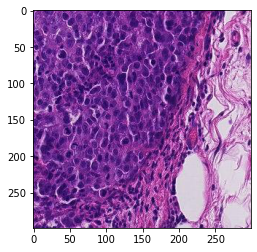

In [ ]:
DIR = 'train_lvl2/1'
img_path = os.listdir(DIR)[0]
img = get_image(DIR,img_path)
plt.imshow(img)

In [ ]:
lvl2_encoder.predict(np.expand_dims(img,axis=0))

array([[0.        , 0.00973509, 0.        , ..., 0.06433041, 0.0014294 ,
        0.        ]], dtype=float32)

In [ ]:
lvl2_encoder.predict(np.expand_dims(img,axis=0)).shape

(1, 2048)

Below is the code I used in order to conver the training set and validation set into the embeddings. I also saved the embeddings so as not to need to do this process every time I want to train the model.

In [ ]:
train_images_1 = {img for img in os.listdir('train_lvl2/1')}
train_images_0 = {img for img in os.listdir('train_lvl2/0')}
train_img = list(train_images_1.union(train_images_0))
random.shuffle(train_img)
train_labels = [1 if img in train_images_1 else 0 for img in train_img]

val_images_1 = {img for img in os.listdir('val_lvl2/1')}
val_images_0 = {img for img in os.listdir('val_lvl2/0')}

val_img = list(val_images_1.union(val_images_0))
random.shuffle(val_img)
val_labels = [1 if img in val_images_1 else 0 for img in val_img]

In [ ]:
def encodings_gen(img_list, dir, labels):
    for img_file ,label in zip(img_list,labels):
        yield np.expand_dims(get_image(os.path.join(dir,str(label)),img_file),axis=0)

In [ ]:
enc_train_lvl2 = lvl2_encoder.predict(encodings_gen(train_img,'train_lvl2',train_labels),steps=len(train_img),verbose=True)
enc_train_lvl3 = lvl3_encoder.predict(encodings_gen(train_img,'train_lvl3',train_labels),steps=len(train_img),verbose=True)
enc_train_lvl5 = lvl5_encoder.predict(encodings_gen(train_img,'train_lvl5',train_labels),steps=len(train_img),verbose=True)

35571/35571 [==============================] - 542s 15ms/step


In [ ]:
with h5py.File('enc_train.h5', 'w') as hf:
    hf.create_dataset("lvl_2",  data=enc_train_lvl2, compression="gzip",compression_opts=9)
    hf.create_dataset("lvl_3",  data=enc_train_lvl3, compression="gzip",compression_opts=9)
    hf.create_dataset("lvl_5",  data=enc_train_lvl5,compression="gzip",compression_opts=9)
    hf.create_dataset("labels",  data=train_labels)

In [ ]:
enc_val_lvl2 = lvl2_encoder.predict(encodings_gen(val_img,'val_lvl2',val_labels),steps=len(val_img),verbose=True)
enc_val_lvl3 = lvl3_encoder.predict(encodings_gen(val_img,'val_lvl3',val_labels),steps=len(val_img),verbose=True)
enc_val_lvl5 = lvl5_encoder.predict(encodings_gen(val_img,'val_lvl5',val_labels),steps=len(val_img),verbose=True)

4667/4667 [==============================] - 71s 15ms/step


In [ ]:
with h5py.File('enc_val.h5', 'w') as hf:
    hf.create_dataset("lvl_2",  data=enc_val_lvl2, compression="gzip",compression_opts=9)
    hf.create_dataset("lvl_3",  data=enc_val_lvl3, compression="gzip",compression_opts=9)
    hf.create_dataset("lvl_5",  data=enc_val_lvl5,compression="gzip",compression_opts=9)
    hf.create_dataset("labels",  data=val_labels)

Below is an data generator that I made to get the embeddings from the their respective files and feed them into the model.

In [ ]:
def img_generator(enc_file, batch_size=32):
    with h5py.File(enc_file, 'r') as hf:
        enc_val_lvl2 = hf["lvl_2"][:]
        enc_val_lvl3 = hf["lvl_3"][:]
        enc_val_lvl5 = hf["lvl_5"][:]
        labels = hf["labels"][:]

        batch_num = 0
        enc_size = enc_val_lvl2.shape[1]

        for i in range(len(labels)):
            if batch_num == 0:
                batch_lvl2 = np.zeros([batch_size,enc_size])
                batch_lvl3 = np.zeros([batch_size,enc_size])
                batch_lvl5 = np.zeros([batch_size,enc_size])
                batch_labels = np.zeros([batch_size])
            
            batch_lvl2[batch_num,:] = enc_val_lvl2[i]
            batch_lvl3[batch_num,:] = enc_val_lvl3[i]
            batch_lvl5[batch_num,:] = enc_val_lvl5[i]
            batch_labels[batch_num] = labels[i]

            batch_num += 1

            if batch_num == batch_size:
                batch_num = 0
                yield ((batch_lvl2,batch_lvl3,batch_lvl5),batch_labels)

## Creating the Ensemble Model

In [ ]:
from tensorflow.keras import models,layers

ENC_SHAPE = (2048,)

zoom_lvl2 = layers.Input(shape=(ENC_SHAPE))
zoom_lvl3 = layers.Input(shape=(ENC_SHAPE))
zoom_lvl5 = layers.Input(shape=(ENC_SHAPE))

x = layers.Concatenate()([zoom_lvl2,zoom_lvl3,zoom_lvl5])
x = layers.Dense(32, activation='relu')(x)

pred = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[zoom_lvl2,zoom_lvl3,zoom_lvl5],outputs=pred)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer = 'adam',
        metrics=[tf.keras.metrics.AUC()])

In [ ]:
batch_size = 32
train_steps = len(train_img) // batch_size
val_steps = len(val_img) // batch_size

In [ ]:
model.fit(img_generator('enc_train.h5'),steps_per_epoch=train_steps, verbose=1, validation_data= img_generator('enc_val.h5'), validation_steps=val_steps)

1111/1111 [==============================] - 7s 6ms/step - loss: 0.0413 - auc_15: 0.9945 - val_loss: 0.3394 - val_auc_15: 0.8365


In [ ]:
model.save('model_ensemble.h5')

An example prediciton:

In [ ]:
model.predict([enc_train_lvl2[0].reshape(1,-1),enc_train_lvl3[0].reshape(1,-1),enc_train_lvl5[0].reshape(1,-1)])

array([[0.0004712]], dtype=float32)

### Evaluating the Ensemble Model

In [ ]:
def get_zoom(slide,x_tl,y_tl,from_level,to_level,size):
    new_x, new_y = x_tl,y_tl
    for i in range(from_level,to_level):
        new_x -= (int(slide.level_downsamples[i]) * size // 2)
        new_y -= (int(slide.level_downsamples[i]) * size // 2)
    return new_x,new_y

In [ ]:
def in_bounds(x,y,slide):
    return (x >= 0) and (y >= 0) and (x <= slide.dimensions[0]) and (y <= slide.dimensions[1])

In [ ]:
def inference_slide_zoom(slide,tumor_mask,level):
    size = 299
    stride = 128
    overlap = size // stride 
    padding = (size - stride) // 2

    num_cols = slide.level_dimensions[level][0]//stride - overlap
    num_rows = slide.level_dimensions[level][1]//stride - overlap

    label_img = np.zeros([num_rows,num_cols])
    predicted = np.zeros([num_rows,num_cols])

    y_true = []
    y_pred = []

    for y_s in tqdm(range(num_rows)):
        for x_s in range(num_cols):
            x_tl = x_s * int(slide.level_downsamples[level]) * stride
            y_tl = y_s * int(slide.level_downsamples[level]) * stride

            slide_image = read_slide(slide,x= x_tl,y= y_tl,level=level,width=size,height=size)
            tissue_pixels = find_tissue_pixels(slide_image)
            percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0])
            
            if percent_tissue > 0.8:            
                n_level = level + 1
                x_nl, y_nl = get_zoom(slide,x_tl,y_tl,level,n_level,size)

                nn_level = level + 3
                x_nnl, y_nnl = get_zoom(slide,x_nl,y_nl,n_level,nn_level,size)

                if in_bounds(x_nnl,y_nnl,slide):
                    n_region = read_slide(slide, x= x_nl, y= y_nl, level=n_level, width=size, height=size)
                    nn_region = read_slide(slide, x= x_nnl, y= y_nnl, level=nn_level, width=size, height=size)
                    mask_image = read_slide(tumor_mask,x= x_tl+padding,y= y_tl+padding,level=level,width=stride,height=stride)

                    enc_lvl2 = lvl2_encoder.predict(np.expand_dims(slide_image,axis=0)).reshape(1,-1)
                    enc_lvl3 = lvl3_encoder.predict(np.expand_dims(n_region,axis=0)).reshape(1,-1)
                    enc_lvl5 = lvl5_encoder.predict(np.expand_dims(nn_region,axis=0)).reshape(1,-1)

                    predicted[y_s,x_s] = model.predict([enc_lvl2,enc_lvl3,enc_lvl5])
                    y_pred.append(predicted[y_s,x_s])

                    mask_image = mask_image[:,:,0]
                    
                    if np.any(mask_image):
                        label_img[y_s,x_s] = 1
                        y_true.append(1)
                    else:
                        label_img[y_s,x_s] = 0
                        y_true.append(0)
                else: 
                    label_img[y_s,x_s] = 0
                    predicted[y_s,x_s] = 0
            else: 
                label_img[y_s,x_s] = 0
                predicted[y_s,x_s] = 0

    print('Label')
    plt.figure(figsize=(10,10))
    plt.imshow(label_img)
    plt.show()

    print('Predicted')
    plt.figure(figsize=(10,10))
    plt.imshow(predicted)
    plt.show()

    auc = roc_auc_score(y_true,y_pred)

    print('AUC for image:',str(auc))

tumor_094.tif
tumor_094_mask.tif



Label


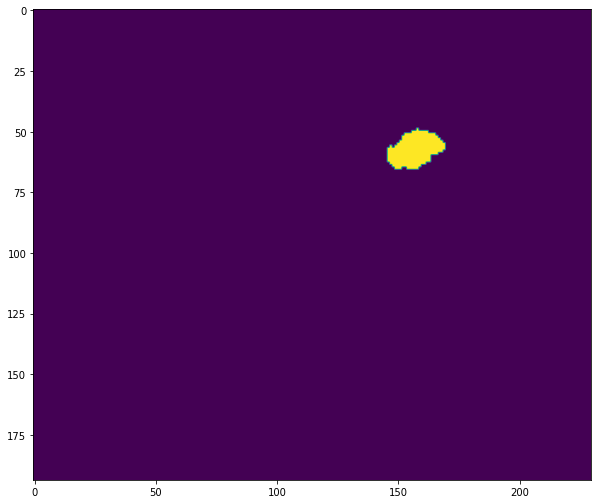

Predicted


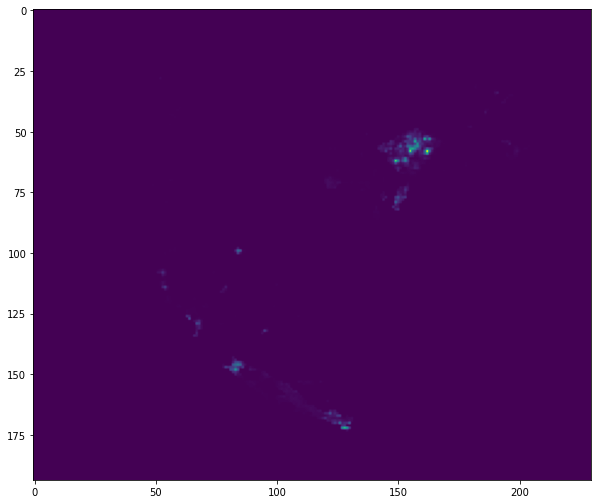

AUC for image: 0.9174721189591077
tumor_096.tif
tumor_096_mask.tif



Label


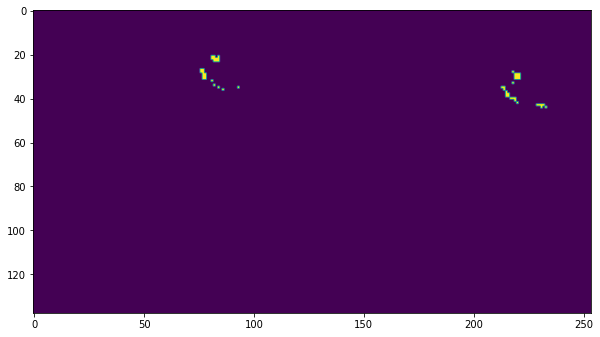

Predicted


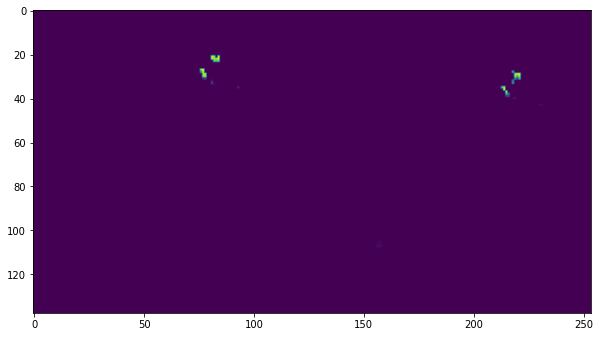

AUC for image: 0.9906447453255963
tumor_101.tif
tumor_101_mask.tif



Label


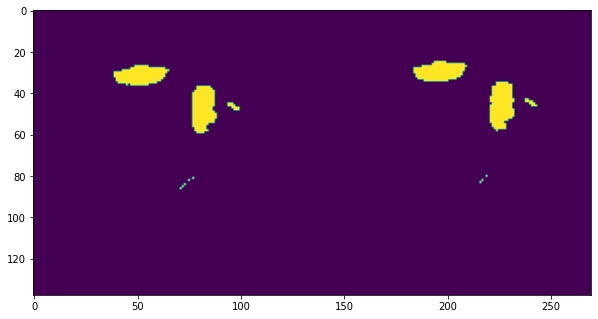

Predicted


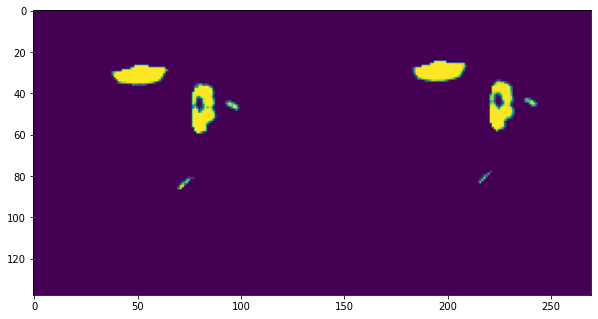

AUC for image: 0.9985831340017304
tumor_110.tif
tumor_110_mask.tif



Label


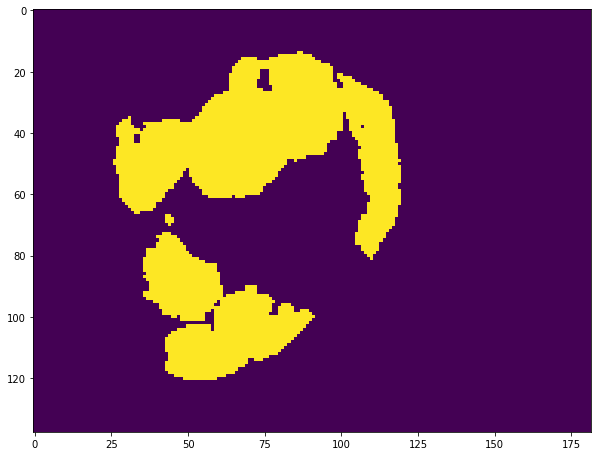

Predicted


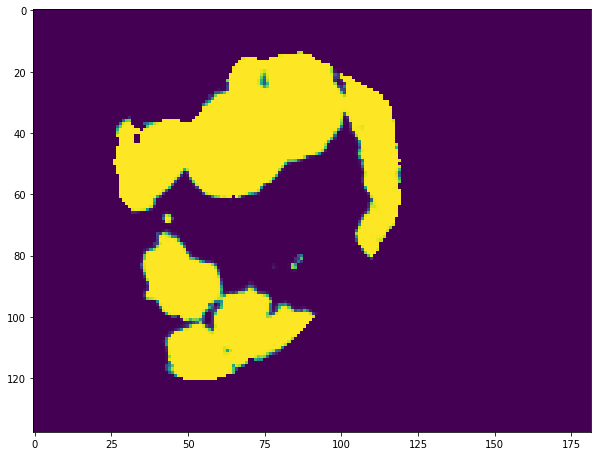

AUC for image: 0.9983815072584766


In [ ]:
urls = gather_urls('test_links.txt')
for image in images:
    slide,tumor_mask,slide_path_file,tm_path_file = get_slide(urls[image])
    inference_slide_zoom(slide,tumor_mask,2)